# Analisis Sentimen App MyPertamina
- **Nama:** NANTHA SEUTIA
- **Email:** ombakrinai@gmail.com

# Library

In [ ]:
# 1. Import library
!pip install google-play-scraper
!pip install Sastrawi

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re
import nltk
import string
import csv
import requests

# Download NLTK resources BEFORE importing word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
from google_play_scraper import app, reviews, Sort, reviews_all

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from io import StringIO
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# Library untuk BoW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Library untuk Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pengumpulan Data

1. Web scraping menggunakan Google Play Scraper.
2. Dataset memiliki minimal 10.000 sampel.
3. Pemberian label kelas sentimen berdasarkan rating (positif, negatif, netral).


In [ ]:
# 2. Data Gathering
# Scraping ulasan aplikasi MyPertamina
scrapreview = reviews_all(
    'com.dafturn.mypertamina',  # ID aplikasi
    lang='id',                  # Bahasa ulasan
    country='id',               # Negara
    sort=Sort.MOST_RELEVANT,    # Urutan ulasan
    count=15000                 # Maksimum jumlah ulasan yang diambil
)

# Konversi hasil scraping ke DataFrame
reviews_df = pd.DataFrame(scrapreview)

# Pastikan dataset memiliki minimal 10.000 sampel
if len(reviews_df) >= 10000:
    print("Dataset memenuhi syarat: >= 10.000 sampel.")
else:
    print("Dataset tidak memenuhi syarat.")

# Simpan dataset ke CSV
reviews_df.to_csv('playstore_reviews.csv', index=False, encoding='utf-8')

# Tampilkan datanya
reviews_df.head()

Dataset memenuhi syarat: >= 10.000 sampel.


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a4994116-a3c1-4a46-9001-1bfdfa10b9a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tadinya sdh bisa registrasi mypertamina dan sd...,1,83,4.6.6,2025-02-01 05:17:32,"Hai, Sobat Zen. Mohon maaf atas ketidaknyamana...",2025-02-01 08:25:03,4.6.6
1,46e5bca6-88fb-4b2a-98aa-03a815d8f7a9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin kesini makin di persulit, mulai dari sud...",1,12,4.6.6,2025-02-08 21:37:29,"Hai, Sobat Julia. Mohon maaf atas ketidaknyama...",2025-02-09 08:37:36,4.6.6
2,b9f04c08-63ed-43d0-9fc1-83b51ccb3415,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Waktu percobaan sukses sampai buat barcode dan...,1,59,4.6.6,2025-01-26 14:15:22,"Hai, Sobat Suharmi. Mohon maaf atas ketidaknya...",2025-01-27 07:20:08,4.6.6
3,81c66434-30e1-4bf4-9ed8-b751eecafef8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Barcode lebih baik di update perbulan, takutny...",4,4,4.6.6,2025-02-06 07:27:09,None,NaT,4.6.6
4,8bb536dd-4c5c-44a1-844d-c0c0a72c15d2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi yang dibuat sangat bagus, terutama sa...",1,11,4.6.6,2025-02-09 06:02:07,"Hai, Sobat Angga. Mohon maaf atas ketidaknyama...",2025-02-09 08:17:15,4.6.6


In [ ]:
# Tampilkan info data
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146627 entries, 0 to 146626
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              146627 non-null  object        
 1   userName              146627 non-null  object        
 2   userImage             146627 non-null  object        
 3   content               146627 non-null  object        
 4   score                 146627 non-null  int64         
 5   thumbsUpCount         146627 non-null  int64         
 6   reviewCreatedVersion  121827 non-null  object        
 7   at                    146627 non-null  datetime64[ns]
 8   replyContent          17654 non-null   object        
 9   repliedAt             17654 non-null   datetime64[ns]
 10  appVersion            121827 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 12.3+ MB


In [ ]:
# Hapus baris yang memiliki nilai yang hilang
clean_review_df = reviews_df.dropna()

# Hapus baris duplikat
clean_review_df = reviews_df.drop_duplicates()

# Tampilkan
clean_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146627 entries, 0 to 146626
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              146627 non-null  object        
 1   userName              146627 non-null  object        
 2   userImage             146627 non-null  object        
 3   content               146627 non-null  object        
 4   score                 146627 non-null  int64         
 5   thumbsUpCount         146627 non-null  int64         
 6   reviewCreatedVersion  121827 non-null  object        
 7   at                    146627 non-null  datetime64[ns]
 8   replyContent          17654 non-null   object        
 9   repliedAt             17654 non-null   datetime64[ns]
 10  appVersion            121827 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 12.3+ MB


# Preprocessing Data
1. Cleaning data
2. Case folding (lowercase)
3. Tokenization
4. Stopword Removal
5. Stemming

In [ ]:
# 3. Processing Data
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords_en = set(stopwords.words('english'))
    listStopwords.update(listStopwords_en)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_review_df['text_clean'] = clean_review_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_review_df['text_casefoldingText'] = clean_review_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_review_df['text_slangwords'] = clean_review_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_review_df['text_tokenizingText'] = clean_review_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_review_df['text_stopword'] = clean_review_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_review_df['text_akhir'] = clean_review_df['text_stopword'].apply(toSentence)

# Pelabelan Data 1

1. Gunakan leksikon data positif dan negatif untuk Bahasa Indonesia
2. Kolom sasaran adalah text_akhir



In [ ]:
# 4. Data Labelling
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    words = text.split()  # Split the text into words!

    for word in words:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in words:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    polarity = ''
    if score > 0:  # Corrected the condition here (no need for >= 0)
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'  # Explicitly set neutral

    return score, polarity

In [ ]:
results = clean_review_df['text_akhir'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_review_df['polarity_score'] = results[0]
clean_review_df['polarity'] = results[1]
print(clean_review_df['polarity'].value_counts())

polarity
negative    80209
neutral     33235
positive    33183
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()

# Fit dan transform kolom 'polarity' menjadi numerik
clean_review_df['label'] = label_encoder.fit_transform(clean_review_df['polarity'])

# Tampilkan mapping label
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Tampilkan 5 baris teratas dengan label
clean_review_df[['polarity', 'label']].head()

{'negative': 0, 'neutral': 1, 'positive': 2}


,polarity,label
0,negative,0
1,negative,0
2,negative,0
3,negative,0
4,negative,0


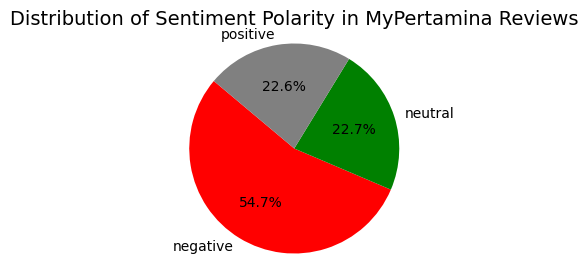

In [ ]:
# Calculate value counts of 'polarity' column
polarity_counts = clean_review_df['polarity'].value_counts()

# Create a DataFrame from the value counts (optional, but good practice)
df = pd.DataFrame({'polarity': polarity_counts.index, 'count': polarity_counts.values})

# Plotting the pie chart
plt.figure(figsize=(4, 3))  # Adjust figure size for better readability

# Define colors
colors = ['red', 'green', 'gray']

# Create the pie chart
plt.pie(df['count'], labels=df['polarity'], colors=colors,
        autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of Sentiment Polarity in MyPertamina Reviews', fontsize=14)

# Ensure the circle's proportion
plt.axis('equal')

# Show the plot
plt.show()

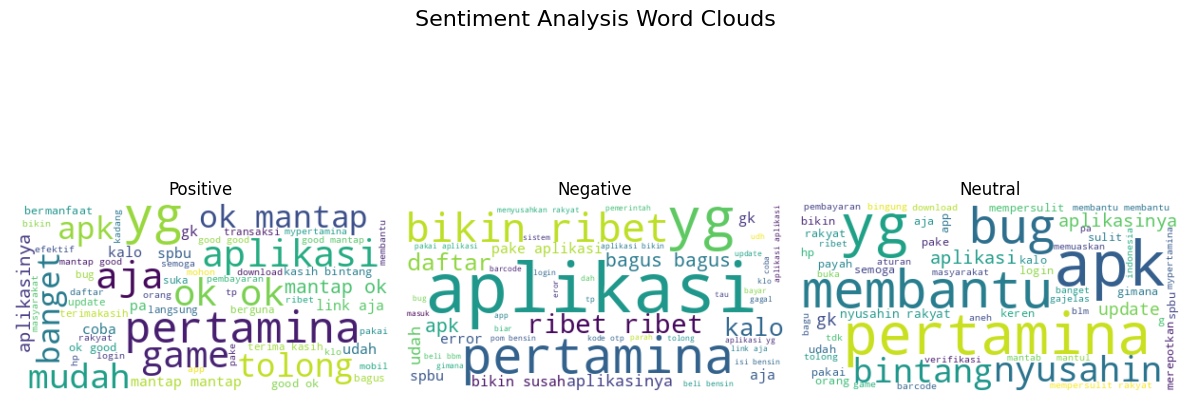

In [ ]:
# Function to generate word cloud (no display inside the function)
def generate_wordcloud(text):
    wordcloud = WordCloud(width=400, height=200,  # Smaller size
                          background_color='white',
                          max_words=100,  # Fewer words for clarity
                          min_font_size=8).generate(' '.join(text))
    return wordcloud


# Separate text by polarity
positive_text = clean_review_df[clean_review_df['polarity'] == 'positive']['text_akhir']
negative_text = clean_review_df[clean_review_df['polarity'] == 'negative']['text_akhir']
neutral_text = clean_review_df[clean_review_df['polarity'] == 'neutral']['text_akhir']

# Generate word clouds
positive_wc = generate_wordcloud(positive_text)
negative_wc = generate_wordcloud(negative_text)
neutral_wc = generate_wordcloud(neutral_text)

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))  # Adjust figure size

# Create a gridspec layout for better spacing
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 1 row, 3 columns

# Plotting the word clouds
ax1 = plt.subplot(gs[0])
ax1.imshow(positive_wc, interpolation='bilinear')
ax1.set_title('Positive', fontsize=12)
ax1.axis("off")

ax2 = plt.subplot(gs[1])
ax2.imshow(negative_wc, interpolation='bilinear')
ax2.set_title('Negative', fontsize=12)
ax2.axis("off")

ax3 = plt.subplot(gs[2])
ax3.imshow(neutral_wc, interpolation='bilinear')
ax3.set_title('Neutral', fontsize=12)
ax3.axis("off")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.suptitle("Sentiment Analysis Word Clouds", fontsize=16)  # Overall title
plt.show()

# Ekstraksi Fitur
1. Term Frequency-Inverse Document Frequency (TF-IDF)

Akurasi Model: 0.7286367046307032

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.67      0.99      0.80     15965
           1       0.93      0.30      0.45      6594
           2       0.95      0.53      0.68      6767

    accuracy                           0.73     29326
   macro avg       0.85      0.61      0.64     29326
weighted avg       0.80      0.73      0.70     29326



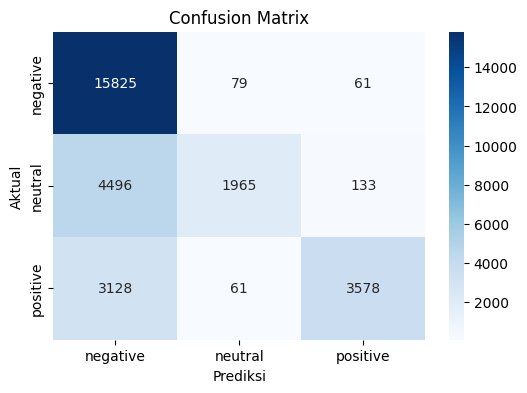

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_review_df['text_akhir'])
y = clean_review_df['label']

# 2. Membagi Dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Memilih Model Machine Learning (Multinomial Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# 4. Evaluasi Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model:", accuracy)
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred))

# 5. Visualisasi Hasil (Confusion Matrix)
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()